# Study of systematic effects on BAO fits 

In this notebook, we will reproduce some tests reported in the BAO measurement using Lyman-alpha forest auto-correlation function from de Sainte Agathe et al. 2019 (https://arxiv.org/abs/1904.03400). In this paper, you will find bestfit parameters for several data samples and several choices of models (see tables 5, 6 and 7). The data samples are:

- Lyman-alpha (in Lya region) x Lyman-alpha (in Lya region)
- Lyman-alpha (in Lya region) x Lyman-alpha (in Lya and Lyb regions)
- Quasars                     x Lyman-alpha (in Lya and Lyb regions)

You will need to download the correlation functions from the svn repository via (you will need a eboss wiki username and password, if not, just ask me):

svn checkout https://svn.sdss.org/repo/eboss/lyaf/dr14/auto/data data

For this tutorial, we will only use the Lyman-alpha auto-correlation in the Lyman-alpha forest region. 

- data/lya_lyaxlya_lya-exported_cf.fits
- data/lya_lyaxlya_lya-metal_dmat.fits

In the paper above, the authors also use the Lyman-alpha absorption in the Lyman-beta region, but for simplicity we will not use them. But of course, feel free to try if you want!

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
import subprocess
import os, time
import h5py
import picca.wedgize
import fitsio

## Reproducing first column of Table 5 of de Sainte Agathe et al. 2019

This first run of the picca_fitter2 will be our starting point. We will run the picca BAO fitter on the Lyman-alpha auto-correlation function.

Please take a look at the following files to see what are the input data, the model choices, and the parameters to be fit, and whether these are fixed or not.

- fits/standard_lya_lyaxlya_lya.ini
- fits/chi2_lyalya.ini



In [17]:
#- Calling fitter 
inifile = 'fits/chi2_lyalya.ini'

if 'PICCA_BASE' in os.environ:
    os.makedirs('logs', exist_ok=True)
    logfilename = 'logs/log_fitter2_run1'
    with open(logfilename, 'a') as logfile:
        picca_base = os.environ['PICCA_BASE']
        print('Starting at {}; should take ~ 15 minutes'.format(time.asctime()))
        command = f'python {picca_base}/bin/picca_fitter2.py {inifile}'
        err = subprocess.call(command.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('picca_fitter2 failed err={}; see {}'.format(err, logfilename))
            raise RuntimeError
        else:
            print('done at {}'.format(time.asctime()))
        
else:
    print('Did you have picca installed? Have you defined the environment variable PICCA_BASE?')

Starting at Thu Jun  6 14:03:03 2019; should take ~ 15 minutes
done at Thu Jun  6 14:18:42 2019


## Reading best-fit alphas and plotting the best-fit model 

The resulting fit is stored in a HDF5 type of file (more info: http://docs.h5py.org/en/stable/quick.html). 

Here we will read it and perform some plots, such as those in Fig. 8 of de Sainte Agathe et al. 2019.


In [72]:
#-- Define class that will read files and plot
class WedgePlotter:
    
    def __init__(self, data_file=None, fit_file=None):
        if data_file:
            self.read_data(data_file)
        if fit_file:
            self.read_fit(fit_file)
            
    def read_data(self, data_file):
        #- Reading the input data file
        h = fitsio.FITS(data_file)
        #-- the correlation function
        da = h[1]['DA'][:]
        print('Correlation function shape:', da.shape)
        #-- the covariance matrix
        co = h[1]['CO'][:]
        print('Covariance matrix shape:', co.shape)

        #-- Reading header 
        hh = h[1].read_header()
        rpmin = hh['RPMIN']
        rpmax = hh['RPMAX']
        rtmin = 0
        rtmax = hh['RTMAX']
        nrp = hh['NP']
        nrt = hh['NT']
        print(f'(rtmin, rtmax) = ({rtmin}, {rtmax})')
        print(f'(rpmin, rpmax) = ({rpmin}, {rpmax})')
        h.close()
        self.da = da
        self.co = co
        self.rpmin = rpmin
        self.rpmax = rpmax
        self.rtmin = rtmin
        self.rtmax = rtmax
        self.nrp = nrp
        self.nrt = nrt
        
    def read_fit(self, fit_file):
        
        ##-- Read the .h5 file
        ff = h5py.File(fit_file, 'r')
        base = list(ff.keys())[0]
        print(list(ff.keys()))
        self.attrs = ff['best fit'].attrs
        self.fit = ff[base+'/fit'][...]
        
    def print_alphas(self):
        #-- The bestfit parameters and other fitter options are stored in the attributes of 'best fit', 
        #-- which is a dictionary
        attrs = self.attrs
        
        #-- Print best-fit parameter and its Gaussian error
        par_names = {'at':'alpha_perp', 'ap':'alpha_parallel'}
        for par in ['at', 'ap']:
            par_value = attrs[par][0]
            par_error = attrs[par][1]
            print(f'{par_names[par]}: {par_value:.3f} +/- {par_error:.3f}')

        chi2 = attrs['fval']
        ndata = attrs['ndata']
        npars = attrs['npar']
        print(f'chi2/(ndata-npars) = {chi2:.2f}/({ndata}-{npars}) = {chi2/(ndata-npars):.2f}')

    def plot_wedges(self, mu_values = [1., 0.95, 0.8, 0.5, 0], power = 2, rmin=10, rmax=180):

        nrows = len(mu_values)-1
        mu_low  = mu_values[:-1]
        mu_high = mu_values[1:]
        f, (axs) = plt.subplots(nrows=nrows, ncols=1, figsize=(6,14))
        for i, (mumax, mumin) in enumerate(zip(mu_low,mu_high)):
            #-- Create wedge object
            b = picca.wedgize.wedge(mumin=mumin, mumax=mumax,
                                    rpmin=self.rpmin, rpmax=self.rpmax, 
                                    rtmin=self.rtmin, rtmax=self.rtmax, 
                                    nrt=self.nrt, nrp=self.nrp, absoluteMu=False)

            #-- Compute wedge for data
            r, wedge_data, wedge_data_cov = b.wedge(self.da, self.co)
            y = wedge_data*r**power
            yerr = np.sqrt(diag(wedge_data_cov))*r**power
            
            axs[i].errorbar(r, y, yerr, fmt="o")

            #-- Compute wedge for model using data covariance matrix
            r, wedge_model, _ = b.wedge(self.fit, self.co) 
            ymod = wedge_model*r**power
            w = (r>=rmin)&(r<=rmax)
            axs[i].plot(r[w], ymod[w], color='red', linewidth=2)
            #axs[i].set_ylabel(r"$r^{}\xi(r)$".format(power))
            if i==nrows-1:
                axs[i].set_xlabel(r"$r \, [h^{-1}\, \mathrm{Mpc}]$")
            axs[i].set_title(r"${}<\mu<{}$".format(mumin,mumax),fontsize=16)
        tight_layout()



In [73]:
#-- Read data and fit with class above
wed = WedgePlotter(data_file='data/lya_lyaxlya_lya-exported_cf.fits',
                   fit_file='fits/fit_lya_lyaxlya_lya.h5')

Correlation function shape: (2500,)
Covariance matrix shape: (2500, 2500)
(rtmin, rtmax) = (0, 200.0)
(rpmin, rpmax) = (0.0, 200.0)
['LYA(LYA)-LYA(LYA)', 'best fit']


In [74]:
wed.print_alphas()

alpha_perp: 0.969 +/- 0.041
alpha_parallel: 1.047 +/- 0.035
chi2/(ndata-npars) = 1619.74/(1590-11) = 1.03


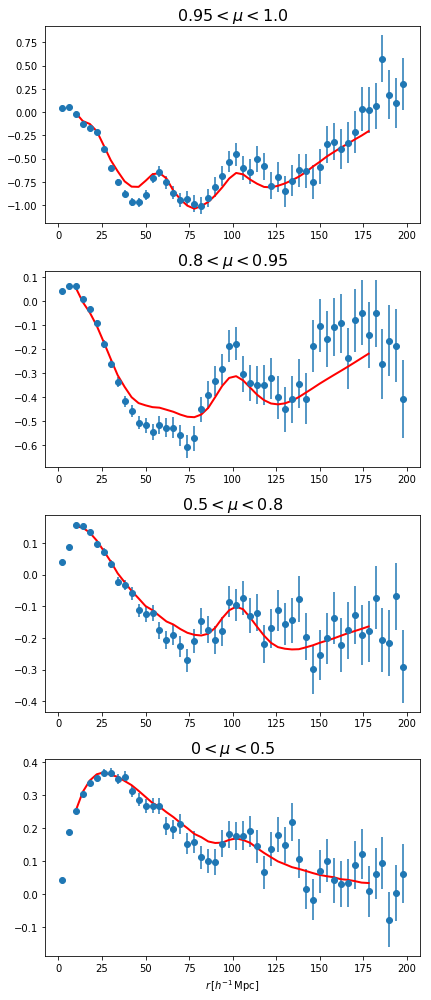

In [69]:
wed.plot_wedges(mu_values=[1., 0.95, 0.8, 0.5, 0], power=2, rmin=10, rmax=180)

## Producing alterative fits: with broadband

What do you think of the best fit model? Do you think it is a good description of the data? 

In this section, we want to look at models with more freedom than the one above. 
In order to do that, we can add (or multiply) polynomials to our physical model. These polynomials do not have a physical interpretation, but are useful to model unknown physics or systematic effects. These polynomials are functions of $r$ and $\mu$ and are written as (Eq. 32 in the paper):

$$B(r, \mu) = \sum_{j=0}^{j_{\rm max}} \sum_{i=i_{\rm min}}^{i_{\rm max}} a_{ij} \frac{L_j(\mu)}{r^i}$$

To start:

1) Make a copy of the two ini files:
   
cp fits/standard_lya_lyaxlya_lya.ini fits/standard_lya_lyaxlya_lya_broadband.ini
   
cp fits/chi2_lyalya.ini fits/chi2_lyalya_broadband.ini

2) Uncomment the lines related to broadband at the end of fits/standard_lya_lyaxlya_lya_broadband.ini

3) Still in fits/standard_lya_lyaxlya_lya_broadband.ini, change the range of the fit for :

r-min = 40

This will avoid some fast variations of the broadband on small scales. 

4) In the fits/chi2_lyalya_broadband.ini, modify:
- the input ini file
- the name of the output

5) Run the fitter again

6) Compare alphas and wedges you obtained from the previous one


In [75]:
#-- Read data and fit with class above
wed_bb = WedgePlotter(data_file='data/lya_lyaxlya_lya-exported_cf.fits',
                      fit_file='fits/fit_lya_lyaxlya_lya_bb.h5')



Correlation function shape: (2500,)
Covariance matrix shape: (2500, 2500)
(rtmin, rtmax) = (0, 200.0)
(rpmin, rpmax) = (0.0, 200.0)
['LYA(LYA)-LYA(LYA)', 'best fit']


In [80]:
print('== No broadband ==')
wed.print_alphas()
print('\n== With broadband ==')
wed_bb.print_alphas()

== No broadband ==
alpha_perp: 0.969 +/- 0.041
alpha_parallel: 1.047 +/- 0.035
chi2/(ndata-npars) = 1619.74/(1590-11) = 1.03

== With broadband ==
alpha_perp: 0.980 +/- 0.043
alpha_parallel: 1.049 +/- 0.034
chi2/(ndata-npars) = 1479.22/(1515-23) = 0.99


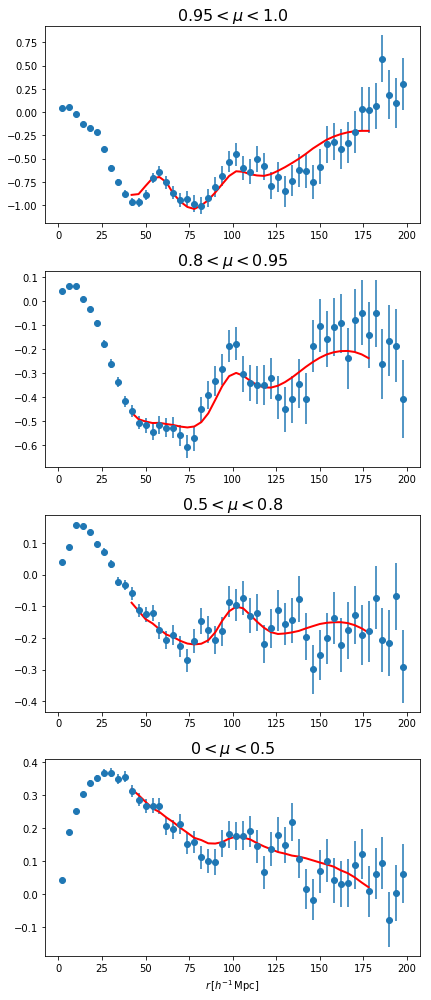

In [79]:
#-- Notice that this model is defined in a different range in r
wed_bb.plot_wedges(rmin=40, rmax=180)

## Computing a systematic error from several fits

You should try now several different fits, varying model, data-cuts, assumptions, priors and obtain several $\alpha_\parallel$ values. We will then estimate a 'systematic error' to be added in quadrature to the baseline statistical errors. 

Ideas of things to vary:
- r-min, r-max: is it better to use scales between $10 < r < 40$ Mpc/h? What about $r<200$ Mpc/h ? 
- rt-min: Since metal correlations are close to rt = 0, what happens if you set rt-min = 10?  
- other broadbands, with higher order polynomials?
- with priors on bias_eta_LYA, beta_LYA, bias_HCD as in the paper. You set the priors using the best-fit values and errors from the baseline fit. 
 

# Converting alphas into Hubble expansion rates

We will now use the fiducial cosmology to convert the obtained $\alpha_\parallel$ into $H(z)$. We will produce Fig. 11 of the paper. 

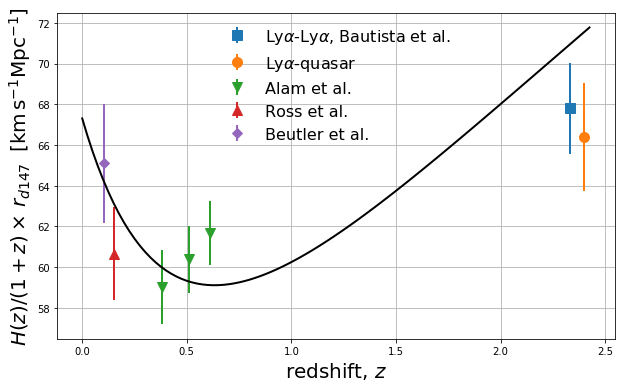

In [3]:
# From Jim's script, I need to clean this 


# From Alacia paper BAO only Table 7
zalacia=[0.38,0.51,0.61]
hrdrdfid= [81.2,90.9,99.0]
ehrdrdfid=[2.5,2.5,2.5]
zalacia=array(zalacia)
hrdrdfid=array(hrdrdfid)
ehrdrdfid=array(ehrdrdfid)
rdfidalacia=147.78
halacia=hrdrdfid*rdfidalacia/147.33
ehalacia=ehrdrdfid
adotalacia=halacia/(1.+zalacia)
eadotalacia=ehalacia/(1.+zalacia)

# from Aubourg et al Table I
zdata=[0.106,0.15,0.57,2.34,2.36]
dhrd= [3.047,4.480,20.75,9.18,9.00]
edhrd=[0.137,0.168,0.73 ,0.28,0.30]
zdata=array(zdata)
dhrd=array(dhrd)
edhrd=array(edhrd)

# new quasar-Lya
dhrd[4]=9.01
edhrd[4]=0.36
zdata[4]=2.4

# new Lya autocorrelation
zdata[3]=2.33
dhrd[3]=9.01
edhrd[3]=0.30

# transform dv to dh at low z
dhrd[1]=dhrd[1]/(zdata[1])
dhrd[0]=dhrd[0]/(zdata[0])
edhrd[1]=edhrd[1]/(zdata[1])
edhrd[0]=edhrd[0]/(zdata[0])

# corrections from smalldist.py
dhrd[1]=dhrd[1]*0.97635925
edhrd[1]=edhrd[1]*0.97635925
dhrd[0]=dhrd[0]*0.982675
edhrd[0]=edhrd[0]*0.982675

dh=dhrd*147.33
adot=2997./((1.+zdata)*dh)
adot=100.*adot
eadot=(edhrd/dhrd)*adot

figure(figsize=(10, 6))
errorbar(zdata[3],adot[3],eadot[3],marker='s',ls='None',fmt='o',lw=2,markersize=10,label=r'Ly$\alpha$-Ly$\alpha$, Bautista et al.')
errorbar(zdata[4],adot[4],eadot[4],marker='o',ls='None',fmt='o',lw=2,markersize=10,label=r'Ly$\alpha$-quasar')
errorbar(zalacia,adotalacia,eadotalacia,marker='v',lw=2,ls='None',fmt='o',markersize=10,label='Alam et al.')
errorbar(zdata[1],adot[1],eadot[1],marker='^',ls='None',fmt='o',lw=2,markersize=10,label='Ross et al.')
errorbar(zdata[0],adot[0],eadot[0],marker='D',ls='None',fmt='o',lw=2,markersize=7,label='Beutler et al.')

ix=arange(98)
z=ix/40.
dhlcdm=(2997.0/0.6731)/sqrt(1. + .315*(((1+z)**3)-1.))
dhrdlcdm=dhlcdm/147.33
adotlcdm=299700.0/((1.+z)*dhlcdm)
plot(z,adotlcdm,lw=2,color='black')

grid()
xlabel(r'redshift, $z$',fontsize=20)
ylabel(r'$H(z)/(1+z) \times \,r_{d147} {\rm  \;\; [km \,s^{-1}Mpc^{-1}]}$',fontsize=20)

legend(loc='upper center',numpoints=1,fontsize=16,frameon=False)




# Calculating tensions with Planck

Previous measurements show a slight tension ($> 2 \sigma$) with Planck predictions for a flat-$\Lambda$CDM model. 

1) What is the tension of the baseline bestfit H(z) with Planck? I.e., what is the distance between our measurement and Planck in units of error bars? 

2) If you add the systematic error you computed for $\alpha_\parallel$, by how much is the tension reduced? 
